[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/example_notebooks/uncertainty_estimation.ipynb)

# Uncertainty Estimation with Quantile Regression


Point estimator provides a single value for the estimated population mean without taking any consideration in uncertainties. Statisticians developed the concept of confidence interval to quantify the model fitting uncertainties. [Prediction interval](https://www.bryanshalloway.com/2021/03/18/intuition-on-uncertainty-of-predictions-introduction-to-prediction-intervals/) has the most accurate estimation among all as it make its prediction on the possible value range for every single individual instance. 

In NeuralProphet, one way to calculate prediction intervals is using quantile regression. This [blog](https://towardsdatascience.com/probabilistic-forecasts-pinball-loss-function-baf86a5a14d0) would be important for you to understand the quantile regression model if you are not familiar with it. With quantile regression, only a certain quantile of output variables are learnt by the algorithm for each instance.

In [1]:
# much faster using the following code, but may not have the latest upgrades/bugfixes
# !pip install neuralprophet  

if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while

Here, we demonstrate the quantile regression feature using the [Peyton Manning dataset](https://github.com/ourownstory/neuralprophet-data/blob/main/datasets/wp_log_peyton_manning.csv). The dataset has recorded the Peyton Manning’s Wikipedia daily page views from 10 December 2007 to 20 January 2016.

In [2]:
import pandas as pd
from neuralprophet import NeuralProphet

data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "wp_log_peyton_manning.csv")

A single 50th percentile regression has been configured as the NeuralProphet forecasting default setting, where we can get a single output as the point estimator for population mean.

To generate a prediction interval, an NeuralProphet object needs a list of at least an upper and lower quantile pair as the parameter. However, you may create as many quantiles as you wish in a NeuralProphet model.

Back to the forecast for our Peyton Manning dataset, assuming we want to have 80% of the true value lay within the interval estimation (i.e. 80% of confidence interval estimate), we create a three-quantiles regression model that outputs the 10th, 50th and 90th percentile values respectively. 

In [3]:
# NeuralProphet only accepts quantiles value in between 0 and 1
confidence_lv = 0.8  
quantile_list = [(1 - confidence_lv) / 2, confidence_lv + (1 - confidence_lv) / 2]

# Create NeuralProphet object with list of quantile as parameter
m = NeuralProphet(quantiles=quantile_list)

NeuralProphet uses pinball loss function to assess goodness-of-fit of the trained model. Similar to the concept of minimising the negative log likelihood loss in a Gaussian linear regression, NeuralProphet builds the quantile regression model by minimising the [pinball loss (quantile loss) function](https://www.lokad.com/pinball-loss-function-definition). 

Instead of taking the absolute error in, pinball loss function has different error weightings for different quantile. We usually take an upper quantile exceeding 50th percentile as the upper bound of prediction interval and another lower quantile below 50th percentile as the lower bound of interval. When the actual output lays outside the prediction interval, the loss function assigns a heavier weight for the absolute error and vice versa. We eventually minimise the loss function by adjusting the parameters of the quantile line iteratively.

Let's see how weighting differs between different lower quantiles (10th vs 25th percentile). Percentile indicates the probability of having the true value below the estimation value. Comparing the 25th percentile, 10th percentile has a smaller expected probability of having the true value below the line. When the actual lays outside the prediction interval (i.e., the actual value is smaller than the predicted one), it is more problematic for a 10th percentile to have such error, as it expects 90% of the true value to be above the line, as opposed to the 75% above the line for the 25th percentile.

In [4]:
# Fit the model with the observations
metrics = m.fit(df, freq="D")

# Create a new dataframe for the results
# Including 100 historical values and 30 value points for the future
future = m.make_future_dataframe(df, periods=30, n_historic_predictions=100)

# Perform prediction with the trained models
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 141
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (93) is too small than the required number for the learning rate finder (237). The results might not be optimal.


Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 93it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


To view the prediction review, you might want to print or to plot `forecast`.

Prediction made for Peyton Manning is visualised below. `yhat1` has shown the prediction made at the 50th percentile while the confidence interval has been shaped in light blue. The lower bound is the prediction result of the 10th quantile whereas the upper one is of the 90th.

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


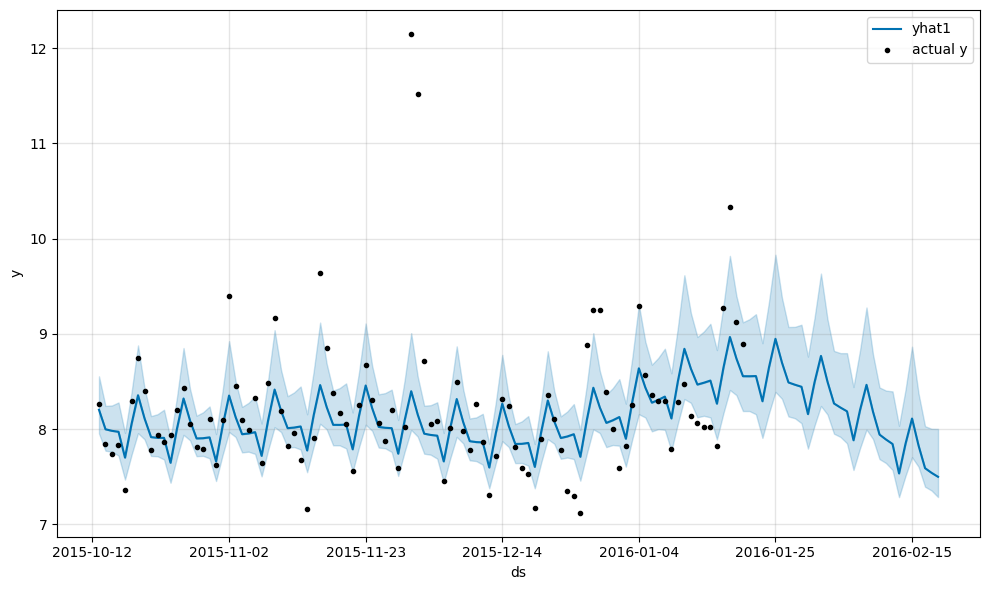

In [5]:
fig_forec = m.plot(forecast)

# Hyperparameter Tuning with Quantile Regression

The quantile regression features can be used along with all other features supported by NeuralProphet. Make sure you have include all the feature-corresponding parameter while you are creating the NeuralProphet model object as well as calling the corresponding feature function afterr creating.
The most common used features paired with quantile regression are events, lagged/future regressors and regularisation. You may want to navigate to other tutorials and feature guide sessions for the detail illustration of most of the features.

By way of example, we will be using another base loss function other than the defaulted pinball loss function in the following quantile regression model.


### Base Loss Functions

As discussed in the previous paragraph, quantile regression uses pinball loss to evaluate the goodness of fit of the NeuralProphet model by default. NeuralPropher offers users the flexibility to change the loss function of quantile regression from pinball loss to Huber , Mean Absolute Error (MAE) or Mean Squared Error (MSE) loss. You just need to define the `loss_func` parameter as `Huber`, `MSE` or `MAE` as shown below.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 141
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (93) is too small than the required number for the learning rate finder (237). The results might not be optimal.


Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 93it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


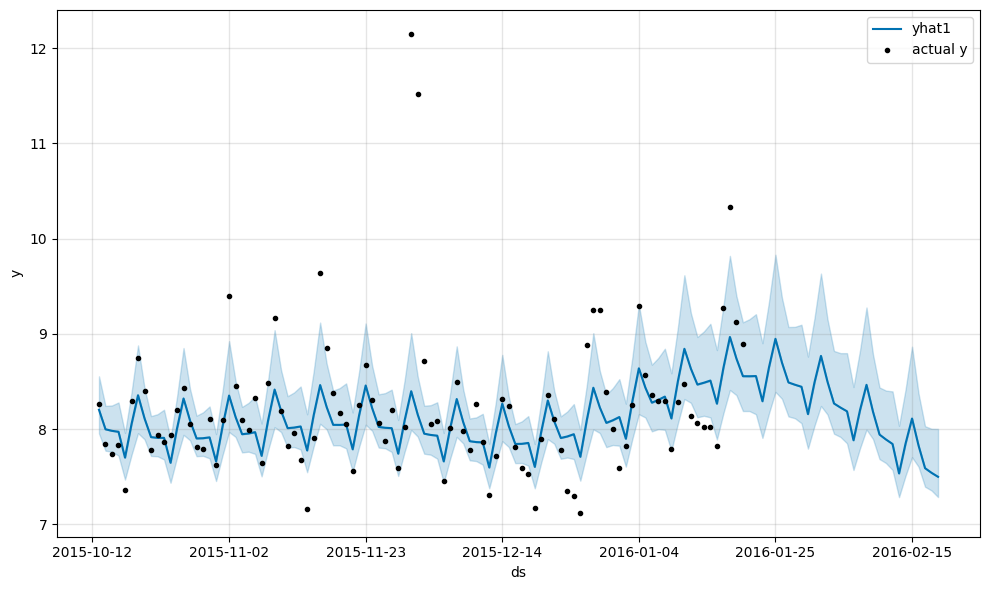

In [6]:
m1 = NeuralProphet(
    loss_func="Huber",    # Changing to lose function from pinball to huber
    quantiles=quantile_list
)
metrics_1 = m1.fit(df, freq="D")
future_1 = m1.make_future_dataframe(df, periods=30, n_historic_predictions=100)
forecast_1 = m1.predict(df=future)
fig_forec_1 = m1.plot(forecast)